# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Download and process subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)

Recount2 data processing:
2a. Download recount2 as RangedSummarizedExperiment(rse) object for each project id provided. Raw reads were mapped to genes using Rail-RNA, which includes exon-exon splice junctions. RSE contains counts summarized at the **gene level** using the **Gencode v25 (GRCh38.p7, CHR) annotation** as provided by Gencode. 

2b. These rse objects return [coverage counts](https://www.bioconductor.org/packages/devel/workflows/vignettes/recountWorkflow/inst/doc/recount-workflow.html) as opposed to read counts and therefore we need to apply [scale_counts](https://rdrr.io/bioc/recount/man/scale_counts.html) to scale by **sample coverage** (average number of reads mapped per nucleotide)

2c. DESeq contains performs an internal normalization where geometric mean is calculated for each gene across all samples. The counts for a gene in each sample is then divided by this mean. The median of these ratios in a sample is the size factor for that sample. This procedure corrects for **library size** (i.e. sequencing depth = total number of reads sequenced for a given sample) and RNA composition bias. DESeq expects [un-normalized](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#input-data) data.

3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_human.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
num_recount2_experiments = params['num_recount2_experiments']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_data_file = params['normalized_compendium_data_file']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

# Load metadata file with grouping assignments for samples
sample_id_metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

### Download subset of recount2 to use as a compendium
The compendium will be composed of random experiments + the selected template experiment

In [4]:
%%R
# Select 59
# Select a
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("derfinder")
#BiocManager::install("recount")

NULL


In [5]:
%%R
suppressPackageStartupMessages(library('recount'))

In [6]:
%%R -i project_id -i num_recount2_experiments -i local_dir -i base_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_compendium(project_id, num_recount2_experiments, local_dir, base_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:55:30 downloading the metadata to /tmp/Rtmp2F2kiO/metadata_clean_sra.Rdata

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://github.com/leekgroup/recount-website/blob/master/metadata/metadata_clean_sra.Rdata?raw=true'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2531337 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 2.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:55:50 downloading file rse_gene.Rdata to SRP045269

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045269/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1963724 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 1.9 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:04 downloading file rse_gene.Rdata to SRP010041

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP010041/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2394059 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:05 downloading file rse_gene.Rdata to SRP038143

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:18 downloading file rse_gene.Rdata to SRP056041

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056041/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3940504 bytes (3.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:19 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:33 downloading file rse_gene.Rdata to SRP034606

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034606/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3305004 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.2 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:52 downloading file rse_gene.Rdata to SRP002621

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002621/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2692623 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:53 downloading file rse_gene.Rdata to SRP045911

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:10 downloading file rse_gene.Rdata to SRP007481

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP007481/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1892560 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:11 downloading file rse_gene.Rdata to SRP051000

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:27 downloading file rse_gene.Rdata to SRP014428

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014428/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 9794038 bytes (9.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 9.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:29 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:49 downloading file rse_gene.Rdata to ERP003933

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003933/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5178540 bytes (4.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.9 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:06 downloading file rse_gene.Rdata to SRP050074

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050074/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1916977 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:08 downloading file rse_gene.Rdata to SRP064820

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:26 downloading file rse_gene.Rdata to ERP003815

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003815/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1967564 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:27 downloading file rse_gene.Rdata to SRP057613

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:49 downloading file rse_gene.Rdata to SRP018779

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP018779/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2442116 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:51 downloading file rse_gene.Rdata to SRP009276

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:11 downloading file rse_gene.Rdata to SRP064457

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064457/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2262483 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:12 downloading file rse_gene.Rdata to SRP032165

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:34 downloading file rse_gene.Rdata to ERP010136

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP010136/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1918542 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:35 downloading file rse_gene.Rdata to SRP013389

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:58 downloading file rse_gene.Rdata to SRP035679

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035679/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1856693 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:00 downloading file rse_gene.Rdata to ERP000992

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:19 downloading file rse_gene.Rdata to SRP001558

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP001558/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2612948 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:20 downloading file rse_gene.Rdata to SRP060715

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:42 downloading file rse_gene.Rdata to SRP039552

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP039552/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2139749 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:44 downloading file rse_gene.Rdata to SRP032953

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

[1] "SRP012651"
Loading objects:
  rse_gene
[1] "SRP014574"
Loading objects:
  rse_gene
[1] "SRP000542"
Loading objects:
  rse_gene
[1] "SRP016059"
Loading objects:
  rse_gene
[1] "SRP001540"
Loading objects:
  rse_gene
[1] "SRP034626"
Loading objects:
  rse_gene
[1] "SRP062873"
Loading objects:
  rse_gene
[1] "SRP041956"
Loading objects:
  rse_gene
[1] "SRP046254"
Loading objects:
  rse_gene
[1] "SRP044956"
Loading objects:
  rse_gene
[1] "SRP045269"
Loading objects:
  rse_gene
[1] "SRP039357"
Loading objects:
  rse_gene
[1] "SRP049238"
Loading objects:
  rse_gene
[1] "SRP021130"
Loading objects:
  rse_gene
[1] "SRP018571"
Loading objects:
  rse_gene
[1] "SRP056201"
Loading objects:
  rse_gene
[1] "SRP060708"
Loading objects:
  rse_gene
[1] "SRP023262"
Loading objects:
  rse_gene
[1] "SRP037775"
Loading objects:
  rse_gene
[1] "SRP041531"
Loading objects:
  rse_gene
[1] "SRP034953"
Loading objects:
  rse_gene
[1] "SRP010041"
Loading objects:
  rse_gene
[1] "SRP038143"
Loading objects:

### Download expression data for selected project id

In [7]:
%%R -i project_id -i local_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:03:24 downloading file rse_gene.Rdata to SRP012656

  warnings.warn(x, RRuntimeWarning)


Loading objects:
  rse_gene


### Subset genes and convert gene names
For our downstream analysis we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), therefore we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [8]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [9]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [10]:
# Get list of our genes

# Read template data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

our_gene_ids = list(template_data.columns)

In [11]:
# File mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    local_dir,
    "ensembl_hgnc_mapping.tsv")

In [12]:
%%R
suppressWarnings(library("biomaRt"))

In [13]:
%%R -i template_data_file -i gene_id_file

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)

source('../generic_expression_patterns_modules/process_names.R')

if (file.exists(gene_id_file) == FALSE){
    gene_id_mapping <- get_ensembl_symbol_mapping(template_data_file, gene_id_file)
}

In [14]:
# Read gene id mapping
gene_id_mapping = pd.read_csv(
        gene_id_file,
        header=0,
        sep='\t',
        index_col=0)

print(gene_id_mapping.shape)
gene_id_mapping.head()

(57210, 2)


,ensembl_gene_id,hgnc_symbol
1,ENSG00000002330,BAD
2,ENSG00000003137,CYP26B1
3,ENSG00000003249,DBNDD1
4,ENSG00000004799,PDK4
5,ENSG00000006062,MAP3K14


In [15]:
# Get mapping between ensembl ids with and without version numbers
# Expressiond data uses ensembl gene ids with version number 
ensembl_gene_ids = pd.DataFrame(data={'ensembl_version': our_gene_ids,
                                      'ensembl_parsed': [gene_id.split('.')[0] for gene_id in our_gene_ids]})

print(ensembl_gene_ids.shape)
ensembl_gene_ids.head()

(58037, 2)


,ensembl_version,ensembl_parsed
0,ENSG00000000003.14,ENSG00000000003
1,ENSG00000000005.5,ENSG00000000005
2,ENSG00000000419.12,ENSG00000000419
3,ENSG00000000457.13,ENSG00000000457
4,ENSG00000000460.16,ENSG00000000460


In [16]:
# Map ensembl ids with version number to gene_id_mapping_df
gene_id_mapping = pd.merge(gene_id_mapping, 
                           ensembl_gene_ids, 
                           left_on='ensembl_gene_id',
                           right_on='ensembl_parsed', 
                           how='outer')

print(gene_id_mapping.shape)
gene_id_mapping.set_index('ensembl_version', inplace=True)
gene_id_mapping.head()

(58129, 4)


,ensembl_gene_id,hgnc_symbol,ensembl_parsed
ensembl_version,,,
ENSG00000002330.13,ENSG00000002330,BAD,ENSG00000002330
ENSG00000003137.8,ENSG00000003137,CYP26B1,ENSG00000003137
ENSG00000003249.13,ENSG00000003249,DBNDD1,ENSG00000003249
ENSG00000004799.7,ENSG00000004799,PDK4,ENSG00000004799
ENSG00000006062.13,ENSG00000006062,MAP3K14,ENSG00000006062


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/viz_template_experiment.ipynb)

In [17]:
# Replace ensembl ids with gene symbols
template_data = process.replace_ensembl_ids(template_data,
                                            gene_id_mapping)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [18]:
template_data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,MIR6830,MIR548AH,MYOCOS,MIR522,MIR6715B,MIR3116-2,MIR3202-2,HSFX3,VINAC1P,MIR4481
SRR493937,622,1,398,394,154,10661,5865,1217,764,1061,...,0,0,13,0,0,0,0,25,0,0
SRR493938,622,0,399,362,159,10761,5770,1184,744,981,...,0,0,12,0,0,0,0,19,0,0
SRR493939,3077,0,629,911,503,941,12913,1768,694,1553,...,0,0,1,0,0,0,0,18,0,0
SRR493940,3041,0,694,918,476,886,12732,1773,695,1540,...,0,0,3,0,0,0,0,18,0,0
SRR493941,551,1,411,563,226,2303,5917,1232,625,963,...,0,0,15,0,0,0,0,33,0,0


In [19]:
# Get intersection of gene lists
our_gene_ids_hgnc = template_data.columns
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))
print(len(shared_genes_hgnc))

17785


In [20]:
# Save shared genes
outfile = open(shared_genes_file,'wb')
pickle.dump(shared_genes_hgnc,outfile)
outfile.close()

In [21]:
if os.path.exists(sample_id_metadata_file):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_file, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)

    template_data = template_data.drop(sample_ids_to_drop)
    
    if project_id == "SRP012656":
        assert(template_data.shape[0] == 24)

In [22]:
# Drop genes
template_data = template_data[shared_genes_hgnc]

print(template_data.shape)
template_data.head()

(24, 17788)


,SHROOM4,NPC1L1,DEK,PTPN18,THOC1,TRPV5,MRPS22,LAIR2,LMAN2,MRPL22,...,MED4,AHNAK,RNASEH2C,PIGN,LINC01449,GINS4,STXBP3,UBFD1,DCN,MIR600HG
SRR493937,1789,29,1855,2758,518,5,513,11,4523,307,...,655,113882,1574,457,0,118,963,999,27300,483
SRR493938,1908,30,1861,2662,480,4,476,17,4360,290,...,734,113390,1509,432,0,132,921,1033,26849,592
SRR493939,1348,14,4024,2632,630,0,447,5,6923,746,...,711,40782,1623,848,3,162,974,2062,15689,319
SRR493940,1329,25,3886,2633,618,1,473,2,6971,699,...,705,41062,1703,796,5,155,973,2012,16008,340
SRR493941,4438,28,1933,2853,525,1,543,3,4462,253,...,727,150995,1776,715,0,50,1024,1496,52306,538


In [23]:
# Round read counts to int
template_data = template_data.astype(int)

In [24]:
print(len(template_data.columns) - len(shared_genes_hgnc))

3


*Note:* There is a difference in the number of `shared_genes_hgnc` and genes in the template experiment because 3 genes have 2 different ensembl gene ids have map to the same hgnc symbol (one forward, one reverse)

### Normalize compendium 

In [25]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(3388, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR493816,525,0,884,428,449,37,532,2370,3393,727,...,0,2,0,0,0,0,13,17,0,0
SRR493817,348,0,790,342,364,57,23,1851,3986,614,...,0,1,0,0,0,0,12,24,0,0
SRR547975,335,0,1978,432,774,0,914,6974,425,2563,...,0,8,0,0,0,0,3,21,0,0
SRR547973,1111,0,1301,863,737,0,0,1912,3475,685,...,0,1,0,0,0,0,36,12,0,0
SRR547968,213,0,717,526,484,0,0,8267,2385,1829,...,0,0,0,0,0,0,24,34,0,0


In [26]:
# Replace ensembl ids with gene symbols
original_compendium = process.replace_ensembl_ids(original_compendium,
                                                gene_id_mapping)

In [27]:
# Drop genes
original_compendium = original_compendium[shared_genes_hgnc]

original_compendium.head()

,SHROOM4,NPC1L1,DEK,PTPN18,THOC1,TRPV5,MRPS22,LAIR2,LMAN2,MRPL22,...,MED4,AHNAK,RNASEH2C,PIGN,LINC01449,GINS4,STXBP3,UBFD1,DCN,MIR600HG
SRR493816,7,10,975,1767,241,1,1251,0,11976,1807,...,595,46823,1944,394,1,362,250,2189,157,407
SRR493817,2,7,798,1671,153,1,866,0,10853,1071,...,406,55508,1448,309,0,311,135,1696,51,406
SRR547975,0,2,9201,1042,881,1,2021,0,3515,1812,...,771,113881,1595,716,0,2445,968,3548,0,464
SRR547973,0,4449,4918,2342,685,0,1627,1,2138,807,...,482,13515,458,574,0,193,1714,2118,6,157
SRR547968,0,10501,5455,1190,968,1,1408,39,3170,894,...,864,48587,754,1225,0,683,791,1610,9,249


In [28]:
# Round compendium read counts to int
original_compendium = original_compendium.astype(int)

In [29]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(3388, 17788)


,SHROOM4,NPC1L1,DEK,PTPN18,THOC1,TRPV5,MRPS22,LAIR2,LMAN2,MRPL22,...,MED4,AHNAK,RNASEH2C,PIGN,LINC01449,GINS4,STXBP3,UBFD1,DCN,MIR600HG
SRR493816,0.000727,0.000952,0.020754,0.063931,0.019694,0.003584,0.139403,0.000000,0.473940,0.080451,...,0.023630,0.181924,0.100725,0.022636,0.032258,0.036603,0.010047,0.120202,0.000813,0.055284
SRR493817,0.000208,0.000667,0.016987,0.060458,0.012503,0.003584,0.096501,0.000000,0.429499,0.047683,...,0.016124,0.215668,0.075026,0.017752,0.000000,0.031446,0.005426,0.093131,0.000264,0.055148
SRR547975,0.000000,0.000190,0.195858,0.037700,0.071995,0.003584,0.225206,0.000000,0.139103,0.080673,...,0.030620,0.442468,0.082642,0.041135,0.000000,0.247219,0.038904,0.194827,0.000000,0.063026
SRR547973,0.000000,0.423674,0.104687,0.084735,0.055978,0.000000,0.181302,0.001560,0.084610,0.035929,...,0.019142,0.052511,0.023731,0.032977,0.000000,0.019515,0.068885,0.116303,0.000031,0.021326
SRR547968,0.000000,1.000000,0.116118,0.043055,0.079104,0.003584,0.156898,0.060842,0.125450,0.039802,...,0.034313,0.188778,0.039067,0.070378,0.000000,0.069060,0.031790,0.088408,0.000047,0.033822


In [30]:
# Save data
template_data.to_csv(
    template_data_file, float_format='%.5f', sep='\t')

original_compendium.to_csv(
    original_compendium_file, float_format='%.3f', sep='\t')

original_data_scaled_df.to_csv(
    normalized_data_file, float_format='%.3f', sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [31]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 3388 samples and 17788 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 2541 samples, validate on 847 samples
Epoch 1/40
2541/2541 [==============================] - 330s 130ms/step - loss: 3221.1959 - val_loss: 3007.9072
Epoch 2/40
2541/2541 [==============================] - 330s 130ms/step - loss: 2943.6953 - val_loss: 2961.9811
Epoch 3/40
2541/2541 [==============================] - 333s 131ms/step - loss: 2913.2871 - val_loss: 2925.5691
Epoch 4/40
2541/2541 [==============================] - 333s 131ms/step - loss: 2882.9977 - val_loss: 2919.8791
Epoch 5/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2861.8532 - val_loss: 2890.8733
Epoch 6/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2850.5113 - val_loss: 2872.4591
Epoch 7/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2827.7885 - val_loss: 2856.9468
Epoch 8/40
2541/2541 [==============================] - 336s 132ms/step - loss: 2812.2756 - val_loss: 2844.2768
Epoch 9/40
2541/2541 [==============================] - 3

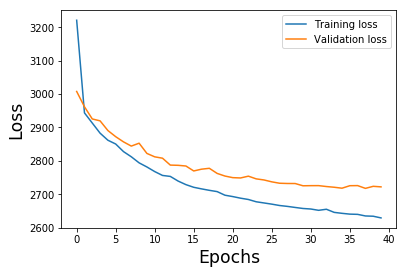

In [32]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                   normalized_data_file)